# Multiple Particle Tracking
-----------------
This code is obtained from DeepTrack2 library notebooks: https://github.com/softmatterlab/DeepTrack2

**Adapted by:** Juan C. Peña and Eberto Benjumea

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%matplotlib inline
!pip install deeptrack

In [3]:
import deeptrack as dt
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import cv2

# SETUP

In [4]:
n = 10 # Number of train image
m = 3 # Number of test image

In [5]:
from deeptrack.models.lodestar.generators import LodeSTARGenerator
from deeptrack.augmentations import Affine
from deeptrack.features import Value

from deeptrack.models.lodestar.equivariances import (
    ScaleEquivariance,
    TranslationalEquivariance,
    Rotational2DEquivariance,
)

In [6]:
# Transformations
a = Affine(translate = lambda: [np.random.randn() * 2] * 2)
b = Affine(rotate = lambda: np.random.rand() * 2 * np.pi * 2)
c = Affine(scale = lambda: [np.random.uniform(low=0.5, high=2)] * 2)

In [7]:
# Define default transformations
DEFAULT_TRANSFORMATION_FUNCTION2 = c >> b >> a

# Define default equivariances
DEFAULT_EQUIVARIANCE2 = ScaleEquivariance(c.scale) >> Rotational2DEquivariance(b.rotate) >> TranslationalEquivariance(a.translate)

In [8]:
class LodeSTARGeneratorUTB(LodeSTARGenerator):
    """Data generator for use with an LodeSTARer.

    Parameters
    ----------
    feature : Feature
        DeepTrack feature returning crops of single objects.
    num_outputs : int
        Number of values the model is expected to predict (not including the weight-map)
    transformation_function : Feature, Feature, optional
        Tuple of features defining transformations applied to each crop as well as the corresponding equivariance.


    """

    def __init__(
        self,
        feature,
        num_outputs=2,
        transformation_function=(DEFAULT_TRANSFORMATION_FUNCTION2, DEFAULT_EQUIVARIANCE2),
        **kwargs
    ):

        transformation_input = Value(
            lambda: (np.eye(num_outputs), np.zeros((num_outputs, 1)))
        )

        self.transformation_function = transformation_function[0] & (
            transformation_input >> transformation_function[1]
        )
        self.num_outputs = num_outputs
        super().__init__(feature, **kwargs)

------------

### Equivariances

In [9]:
from deeptrack.models.lodestar.equivariances import Equivariance

class TranslationalEquivariance(Equivariance):
    """Defines translation-like equivariance between action and prediction, for use with dt.Affine

    Parameters
    ----------
    translate : float, array-like
        Should be exactly `affine.translate`

    """

    def __init__(self, translation, indexes=None):
        if indexes is None:
            indexes = self.get_indexes
        super().__init__(
            translation=translation, add=self.get_add, mul=self.get_mul, indexes=indexes
        )

    def get_add(self, translation):
        return np.array(translation[::-1]).reshape((-1, 1))

    def get_mul(self, translation):
        return np.eye(len(translation))

    def get_indexes(self, translation):
        return slice(len(translation))

In [10]:
a.translate

In [11]:
t1 = TranslationalEquivariance(a.translate)
add = t1.get_add([np.random.randn() * 2] * 2)
mul = t1.get_mul([np.random.randn() * 2] * 2)
idx = t1.get_indexes([np.random.randn() * 2] * 2)

In [12]:
add

array([[-2.0979895],
       [-2.0979895]])

In [13]:
mul

array([[1., 0.],
       [0., 1.]])

In [14]:
idx

slice(None, 2, None)

-----------

## 1- 3D Wheals

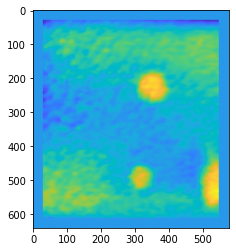

In [12]:
# Preprocessing

#image = dt.LoadImage(f'../input/wheals-data/Data/jpg/train/images/{n}.jpg')()._value / 256
path = f'/content/drive/MyDrive/Investigacion/Data/jpg/train/images/{n}.jpg'
image = dt.LoadImage(path)()._value / 255

# plt.imshow(image)
plt.imshow(image, cmap='gray')

(96, 87)


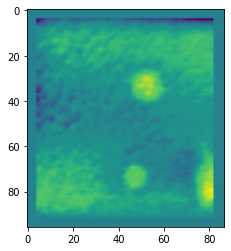

In [13]:
gray_image = 0.21*image[:,:,0] + 0.72*image[:,:,1] + 0.07*image[:,:,2] # Convert to grayscale manually

# Resizing
resized_image = cv2.resize(gray_image, (0, 0), fx=0.15, fy=0.15)
plt.imshow(resized_image)
print(resized_image.shape)
#plt.axis("off")

(40, 40)
(40, 40, 1)


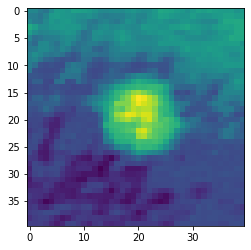

In [14]:
# Cropping
t, x, y, w = (251, 32, 14, 40) # n = 10

crop = resized_image[y:y+w, x:x+w]
print(crop.shape)
plt.imshow(crop)
training_image = np.expand_dims(crop, axis = 2) # Add a third channel
print(training_image.shape)
#plt.axis("off")

In [16]:
train_set =   (
    dt.Value(training_image)
    >> dt.Add(lambda: np.random.randn() * 0.1)
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.2))  
    >> dt.Multiply(lambda: np.random.uniform(0.6, 1.2))
)

In [17]:
model = dt.models.LodeSTAR(input_shape=(None, None, 1))

In [18]:
model.data_generator = LodeSTARGeneratorUTB

In [19]:
model.build(input_shape = (None, None, 1))
model.summary()

Model: "lode_star_base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     249827    
                                                                 
Total params: 249,827
Trainable params: 249,827
Non-trainable params: 0
_________________________________________________________________


In [20]:
#@title
# Training
history = model.fit(
    train_set,
    epochs=40,
    batch_size=8,
)

# Saving weights
model.save_weights('./model.h5')

Generating 161 / 160 samples before starting training
Epoch 1/40
161/161 [==============================] - 11s 13ms/step - total_loss: 3.0437 - consistency_loss: 1.5094
Epoch 2/40
161/161 [==============================] - 3s 15ms/step - total_loss: 2.9246 - consistency_loss: 1.4073
Epoch 3/40
161/161 [==============================] - 2s 14ms/step - total_loss: 2.6822 - consistency_loss: 1.2240
Epoch 4/40
161/161 [==============================] - 2s 15ms/step - total_loss: 2.1981 - consistency_loss: 0.9025
Epoch 5/40
161/161 [==============================] - 2s 14ms/step - total_loss: 0.6517 - consistency_loss: 0.2988
Epoch 6/40
161/161 [==============================] - 1s 8ms/step - total_loss: 0.3062 - consistency_loss: 0.1069
Epoch 7/40
161/161 [==============================] - 2s 13ms/step - total_loss: 0.2649 - consistency_loss: 0.0750
Epoch 8/40
161/161 [==============================] - 2s 14ms/step - total_loss: 0.1954 - consistency_loss: 0.0562
Epoch 9/40
161/161 [======

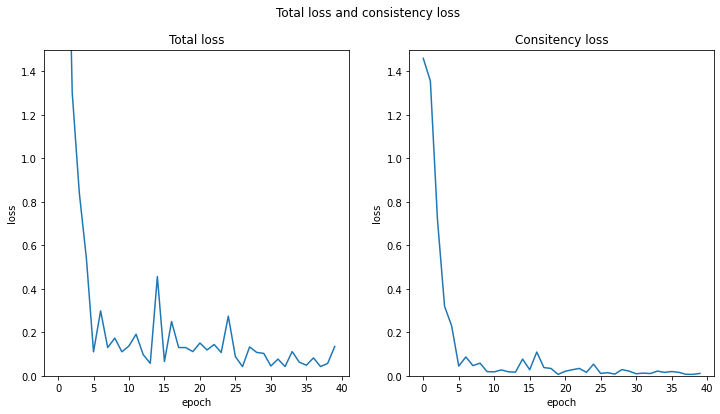

In [21]:
# list all data in history
# print(history.history.keys())

#Summarize history for total_loss and consistency_loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Total loss and consistency loss')

ax1.plot(history.history['total_loss'])
ax1.set_title('Total loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.set_ylim([0, 1.5])
# ax1.legend(['train', 'test'], loc='upper left')

ax2.plot(history.history['consistency_loss'])
ax2.set_title('Consitency loss')
ax2.set(xlabel='epoch', ylabel='loss')
ax2.set_ylim([0, 1.5])

plt.show()

In [24]:
# Loading weights
model.build(input_shape = (None, None, 1))
model.load_weights('/content/drive/MyDrive/Investigacion/Model/model.h5')

1/1 [==============================] - 0s 371ms/step


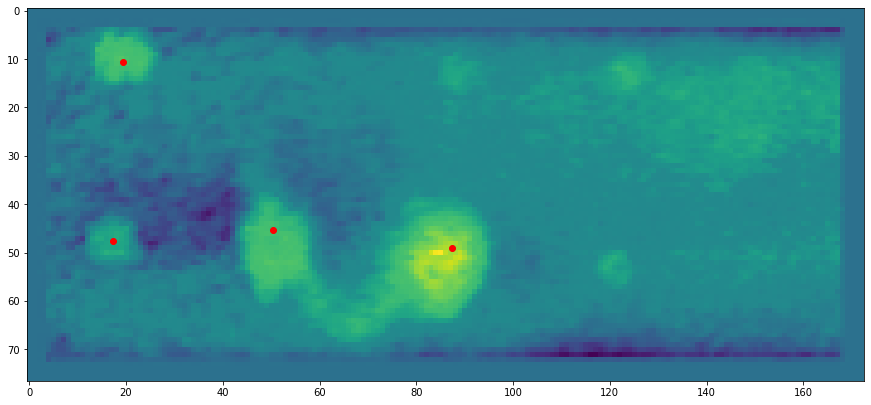

In [22]:
#May need to tune these to get optimal performance!
alpha = 0.2
cutoff = 0.99

path2 = f'/content/drive/MyDrive/Investigacion/Data/jpg/train/images/{3}.jpg'
image2 = dt.LoadImage(path2)()._value / 256
gray_image2 = 0.21*image2[:,:,0] + 0.72*image2[:,:,1] + 0.07*image2[:,:,2] # Convert to grayscale manually
resized_image2 = cv2.resize(gray_image2, (0, 0), fx=0.15, fy=0.15)
test_image = np.expand_dims(resized_image2, axis = 2) # Add a third channel

detections = model.predict_and_detect(test_image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]
# detections = autotracker.detect(pred[0], weights[0], beta=1-alpha, alpha=alpha, cutoff=cutoff, mode="constant")

plt.figure(figsize=(15, 15))
plt.imshow(resized_image2)
#plt.axis("off")
plt.scatter(detections[:, 1], detections[:, 0], color="r")

1/1 [==============================] - 0s 196ms/step


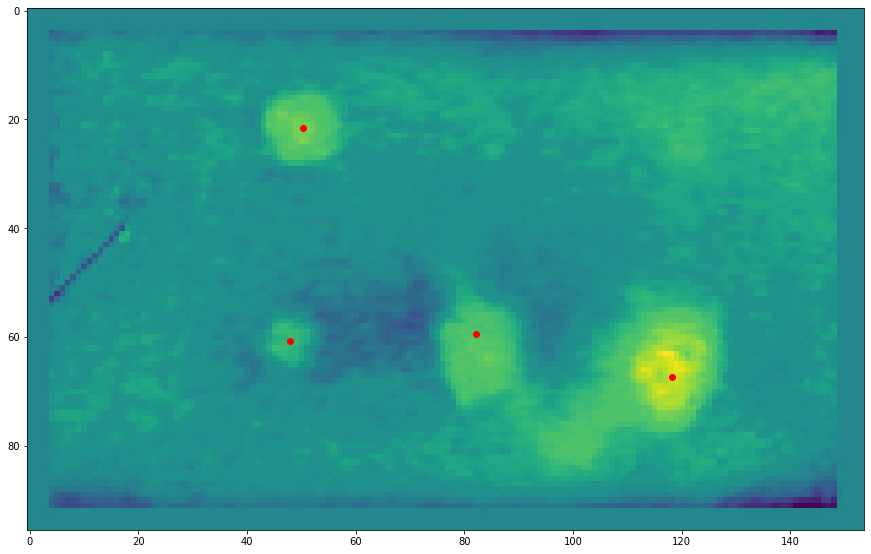

In [38]:
#May need to tune these to get optimal performance!
alpha = 0.2
cutoff = 0.99

path2 = f'/content/drive/MyDrive/Investigacion/Data/jpg/test/images/{1}.jpg'
image2 = dt.LoadImage(path2)()._value / 256
gray_image2 = 0.21*image2[:,:,0] + 0.72*image2[:,:,1] + 0.07*image2[:,:,2] # Convert to grayscale manually
resized_image2 = cv2.resize(gray_image2, (0, 0), fx=0.15, fy=0.15)
test_image = np.expand_dims(resized_image2, axis = 2) # Add a third channel

detections = model.predict_and_detect(test_image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]
# detections = autotracker.detect(pred[0], weights[0], beta=1-alpha, alpha=alpha, cutoff=cutoff, mode="constant")

plt.figure(figsize=(15, 15))
plt.imshow(resized_image2)
#plt.axis("off")
plt.scatter(detections[:, 1], detections[:, 0], color="r")

In [26]:
# test_images = 

In [27]:
# Evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)

## 2- Synthetic images

#### a. With similar size

(1026, 1281, 3)


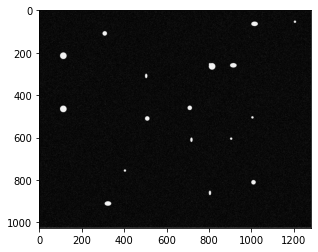

In [28]:
# Preprocessing
path = f'/content/drive/MyDrive/Investigacion/Data/synthetics/sinteticav5_circles_noisy.png'
#path = f'/content/drive/MyDrive/Investigacion/Data/synthetics/sinteticav5_squares_noisy.png'
#path = f'/content/drive/MyDrive/Investigacion/Data/synthetics/sinteticav3_noisy.png'

image = dt.LoadImage(path)()._value / 256
image3 = cv2.merge((image, image, image))

print(image3.shape)
plt.imshow(image3, cmap='gray')

(154, 192)


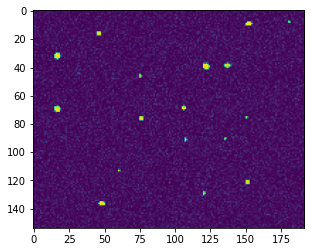

In [29]:
# Resizing
resized_image = cv2.resize(image, (0, 0), fx=0.15, fy=0.15)
plt.imshow(resized_image)
print(resized_image.shape)
#plt.axis("off")

(40, 40)
(40, 40, 1)


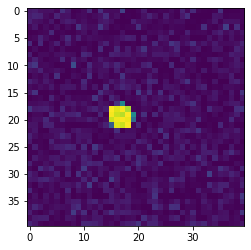

In [30]:
# Cropping
t, x, y, w = (251, 0, 50, 40)

crop = resized_image[y:y+w, x:x+w]
print(crop.shape)
plt.imshow(crop)
training_image = np.expand_dims(crop, axis = 2) # Add a third channel
print(training_image.shape)
#plt.axis("off")

In [31]:
train_set =   (
    dt.Value(training_image)
    >> dt.Add(lambda: np.random.randn() * 0.1)
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.2))  
    >> dt.Multiply(lambda: np.random.uniform(0.6, 1.2))
)

In [32]:
model2 = dt.models.LodeSTAR(input_shape=(None, None, 1))

In [33]:
model2.data_generator = LodeSTARGeneratorUTB

In [34]:
# Training
model2.fit(
    train_set,
    epochs=40,
    batch_size=8,
)

# Saving weights
model2.save_weights('./model_synth_circles.h5')

Generating 161 / 160 samples before starting training
Epoch 1/40
161/161 [==============================] - 6s 13ms/step - total_loss: 1.7239 - consistency_loss: 0.8606
Epoch 2/40
161/161 [==============================] - 2s 14ms/step - total_loss: 0.1972 - consistency_loss: 0.0510
Epoch 3/40
161/161 [==============================] - 2s 12ms/step - total_loss: 0.0954 - consistency_loss: 0.0182
Epoch 4/40
161/161 [==============================] - 2s 14ms/step - total_loss: 0.0812 - consistency_loss: 0.0111
Epoch 5/40
161/161 [==============================] - 2s 14ms/step - total_loss: 0.0881 - consistency_loss: 0.0102
Epoch 6/40
161/161 [==============================] - 2s 13ms/step - total_loss: 0.0962 - consistency_loss: 0.0210
Epoch 7/40
161/161 [==============================] - 2s 14ms/step - total_loss: 0.1076 - consistency_loss: 0.0277
Epoch 8/40
161/161 [==============================] - 2s 14ms/step - total_loss: 0.0691 - consistency_loss: 0.0099
Epoch 9/40
161/161 [======

In [35]:
# Loading weights
model2.build(input_shape = (None, None, 1))
model2.load_weights('./model_synth_circles.h5')

1/1 [==============================] - 0s 411ms/step


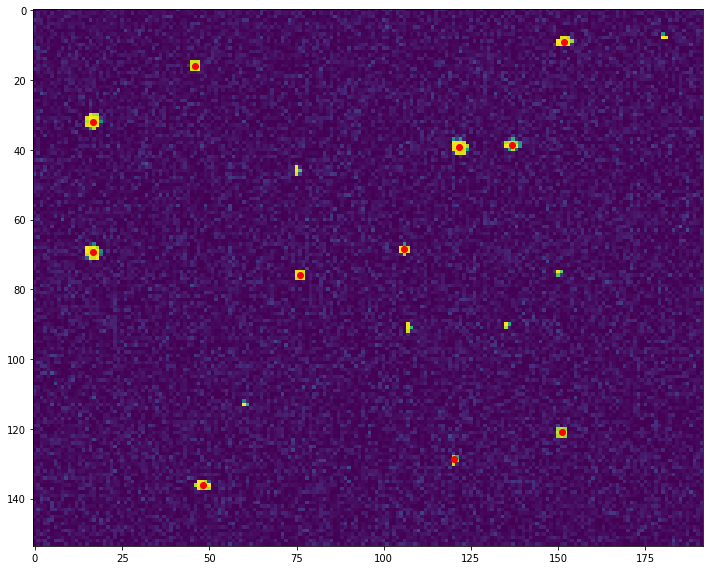

In [36]:
#May need to tune these to get optimal performance!
alpha = 0.2
cutoff = 0.99

path2 = f'/content/drive/MyDrive/Investigacion/Data/synthetics/sinteticav5_circles_noisy.png'
image2 = dt.LoadImage(path2)()._value / 256

resized_image2 = cv2.resize(image2, (0, 0), fx=0.15, fy=0.15)
test_image = np.expand_dims(resized_image2, axis = 2) # Add a third channel

detections = model2.predict_and_detect(test_image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]

plt.figure(figsize=(12, 12))
plt.imshow(resized_image2)
#plt.axis("off")
plt.scatter(detections[:, 1], detections[:, 0], color="r")

1/1 [==============================] - 0s 29ms/step


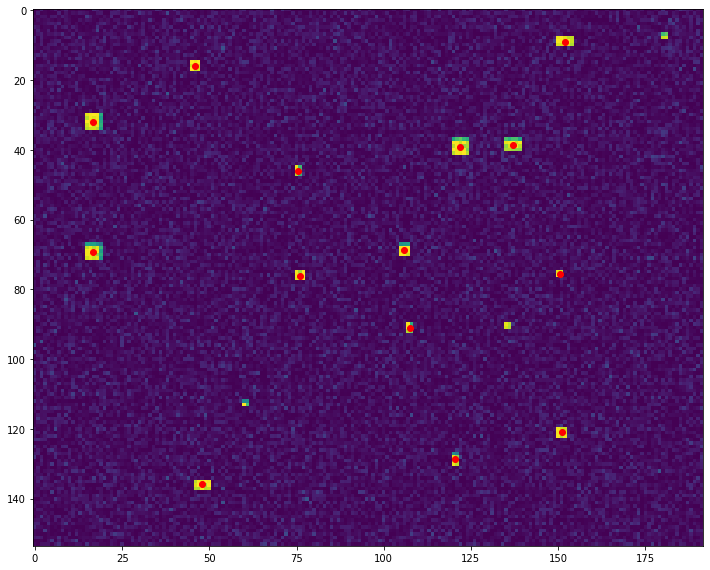

In [37]:
#May need to tune these to get optimal performance!
alpha = 0.2
cutoff = 0.99

path2 = f'/content/drive/MyDrive/Investigacion/Data/synthetics/sinteticav5_squares_noisy.png'
image2 = dt.LoadImage(path2)()._value / 256

resized_image2 = cv2.resize(image2, (0, 0), fx=0.15, fy=0.15)
test_image = np.expand_dims(resized_image2, axis = 2) # Add a third channel

detections = model2.predict_and_detect(test_image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]

plt.figure(figsize=(12, 12))
plt.imshow(resized_image2)
#plt.axis("off")
plt.scatter(detections[:, 1], detections[:, 0], color="r")

#### b. With very different sizes

##### SETUP

In [38]:
# Transformations
d = Affine(translate = lambda: [np.random.randn() * 2] * 2)
e = Affine(rotate = lambda: np.random.rand() * 2 * np.pi * 2)
f = Affine(scale = lambda: [np.random.uniform(low=0.7, high=7)] * 2)

In [39]:
# Define default transformations
DEFAULT_TRANSFORMATION_FUNCTION2 = f >> e >> d

# Define default equivariances
DEFAULT_EQUIVARIANCE2 = ScaleEquivariance(f.scale) >> Rotational2DEquivariance(e.rotate) >> TranslationalEquivariance(d.translate)

In [40]:
class LodeSTARGeneratorUTB2(LodeSTARGenerator):
    """Data generator for use with an LodeSTARer.

    Parameters
    ----------
    feature : Feature
        DeepTrack feature returning crops of single objects.
    num_outputs : int
        Number of values the model is expected to predict (not including the weight-map)
    transformation_function : Feature, Feature, optional
        Tuple of features defining transformations applied to each crop as well as the corresponding equivariance.


    """

    def __init__(
        self,
        feature,
        num_outputs=2,
        transformation_function=(DEFAULT_TRANSFORMATION_FUNCTION2, DEFAULT_EQUIVARIANCE2),
        **kwargs
    ):

        transformation_input = Value(
            lambda: (np.eye(num_outputs), np.zeros((num_outputs, 1)))
        )

        self.transformation_function = transformation_function[0] & (
            transformation_input >> transformation_function[1]
        )
        self.num_outputs = num_outputs
        super().__init__(feature, **kwargs)

(530, 725, 3)


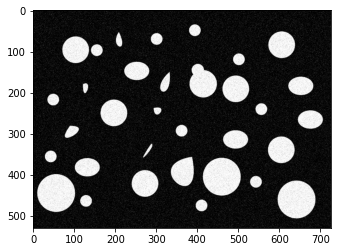

In [41]:
# Preprocessing
path = f'/content/drive/MyDrive/Investigacion/Data/synthetics/sinteticav3_noisy.png'

image = dt.LoadImage(path)()._value / 256
image3 = cv2.merge((image, image, image))

print(image3.shape)
plt.imshow(image3, cmap='gray')

(80, 109)


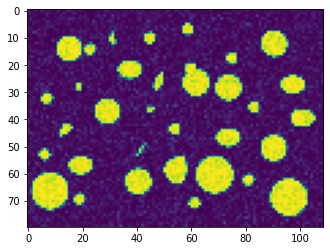

In [42]:
# Resizing
resized_image = cv2.resize(image, (0, 0), fx=0.15, fy=0.15)
plt.imshow(resized_image)
print(resized_image.shape)
#plt.axis("off")

(20, 20)
(20, 20, 1)


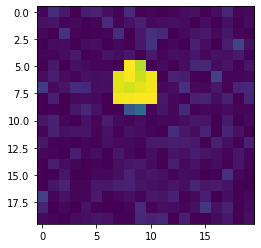

In [43]:
# Cropping
t, x, y, w = (251, 50, 0, 20)

crop = resized_image[y:y+w, x:x+w]
print(crop.shape)
plt.imshow(crop)
training_image = np.expand_dims(crop, axis = 2) # Add a third channel
print(training_image.shape)
#plt.axis("off")

In [44]:
train_set =   (
    dt.Value(training_image)
    >> dt.Add(lambda: np.random.randn() * 0.1)
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.2))  
    >> dt.Multiply(lambda: np.random.uniform(0.6, 1.2))
)

In [45]:
model3 = dt.models.LodeSTAR(input_shape=(None, None, 1))

In [46]:
model3.data_generator = LodeSTARGeneratorUTB2

In [47]:
# Training
model3.fit(
    train_set,
    epochs=40,
    batch_size=8,
)

# Saving weights
model3.save_weights('./model_synth_diff_shapes_sizes.h5')

Generating 164 / 160 samples before starting training
Epoch 1/40
164/164 [==============================] - 8s 14ms/step - total_loss: 1.0214 - consistency_loss: 0.3417
Epoch 2/40
164/164 [==============================] - 2s 14ms/step - total_loss: 0.1494 - consistency_loss: 0.0279
Epoch 3/40
164/164 [==============================] - 2s 15ms/step - total_loss: 0.1063 - consistency_loss: 0.0152
Epoch 4/40
164/164 [==============================] - 2s 15ms/step - total_loss: 0.0784 - consistency_loss: 0.0092
Epoch 5/40
164/164 [==============================] - 2s 14ms/step - total_loss: 0.0742 - consistency_loss: 0.0075
Epoch 6/40
164/164 [==============================] - 2s 14ms/step - total_loss: 0.1034 - consistency_loss: 0.0156
Epoch 7/40
164/164 [==============================] - 2s 14ms/step - total_loss: 0.0805 - consistency_loss: 0.0094
Epoch 8/40
164/164 [==============================] - 3s 15ms/step - total_loss: 0.0664 - consistency_loss: 0.0064
Epoch 9/40
164/164 [======

KeyboardInterrupt: ignored

In [ ]:
# Loading weights
model3.build(input_shape = (None, None, 1))
model3.load_weights('./model_synth_diff_shapes_sizes.h5')

In [ ]:
#May need to tune these to get optimal performance!
alpha = 0.2
cutoff = 0.99

path2 = f'/content/drive/MyDrive/Investigacion/Data/synthetics/sinteticav3_noisy.png'
image2 = dt.LoadImage(path2)()._value / 256

resized_image2 = cv2.resize(image2, (0, 0), fx=0.15, fy=0.15)
test_image = np.expand_dims(resized_image2, axis = 2) # Add a third channel

detections = model3.predict_and_detect(test_image[np.newaxis], alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]

plt.figure(figsize=(15, 15))
plt.imshow(resized_image2)
#plt.axis("off")
plt.scatter(detections[:, 1], detections[:, 0], color="r")